# TOC entitlements near bus/rail lines
* Which bus/rail lines or rail stations have seen the most TOC entitlement activity?
* Which ones have seen lots of non-TOC entitlement activity? 

In [1]:
import functools
import contextily
import intake
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import utils
import boto3

In [ ]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 20)

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

## Assign entitlements to conditions

In [3]:
toc_tiers = utils.reconstruct_toc_tiers_file()

parcels = gpd.read_file(
    f"s3://{bucket_name}/gis/intermediate/toc_eligible_parcels_with_entitlements.geojson"
).to_crs({'init':'epsg:4326'})

In [4]:
toc_parcels = parcels[parcels.num_TOC > 0]

In [5]:
df = utils.parcels_join_toc_tiers(toc_parcels, toc_tiers)

## Which rule?

In [6]:
tier_1 = df[df.TOC_Tier == 1]
tier_2 = df[df.TOC_Tier == 2]
tier_3 = df[df.TOC_Tier == 3]
tier_4 = df[df.TOC_Tier == 4]

Text(0.6, -1.0, 'TOC Entitlements')

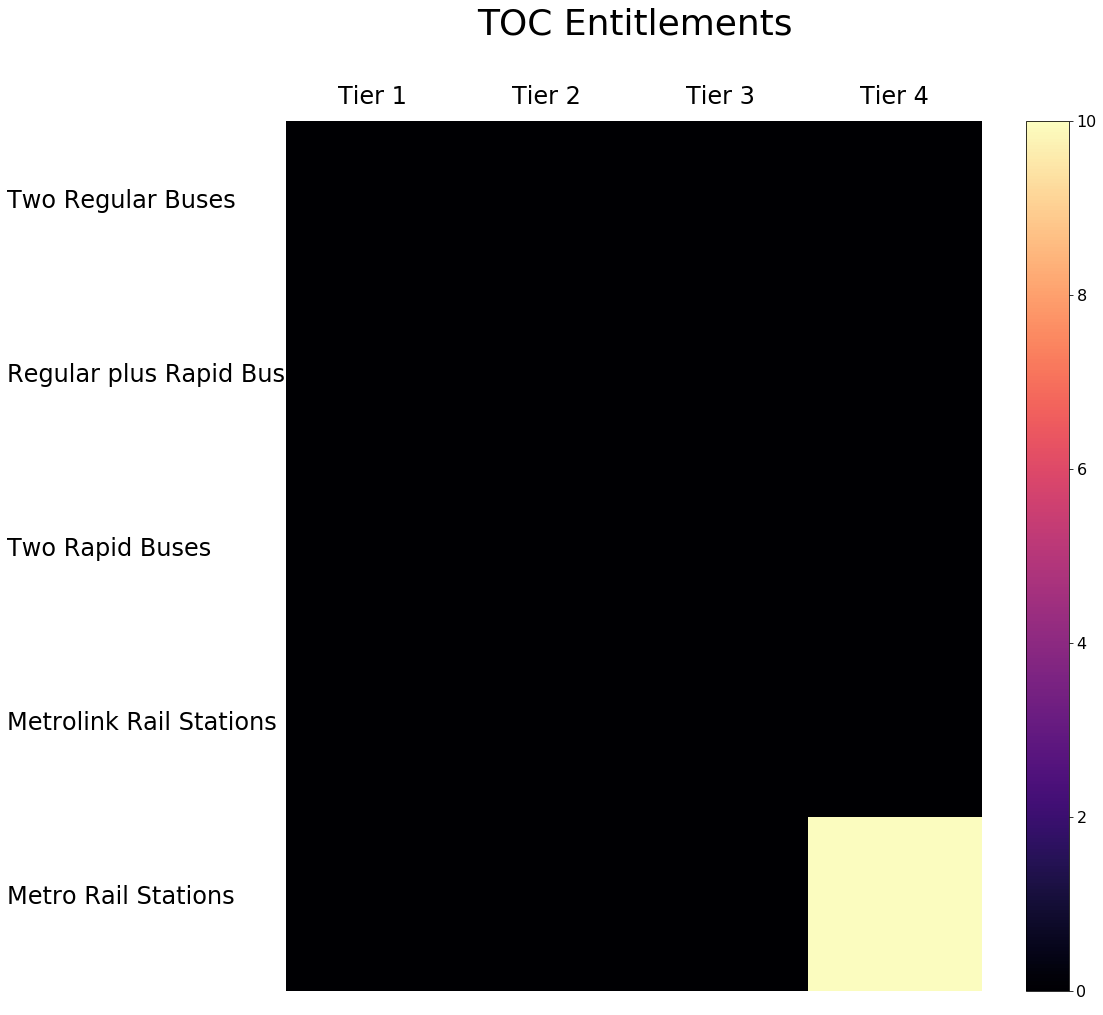

In [14]:
table = np.zeros(shape=(5, 4))
table[4,3] = tier_4[tier_4.mode_a=="metro"].dropna(subset=["station_name"]).num_TOC.sum()
""" 
table[4,2] = tier_4[tier_4.mode_a=="metro"].dropna(subset=["station_name"]).num_TOC.sum()
table[3,2] = tier_3[tier_3.mode_a=="metrolink"].dropna(subset=["station_name"]).num_TOC.sum()
table[3,1] = tier_2[tier_2.mode_a=="metrolink"].dropna(subset=["station_name"]).num_TOC.sum()
table[3,0] = tier_1[tier_1.mode_a=="metrolink"].dropna(subset=["station_name"]).num_TOC.sum()
table[2,2] = tier_3[tier_3.a_rapid & tier_3.b_rapid].dropna(subset=["line_id_a"]).num_TOC.sum()
table[2,1] = tier_2[tier_2.a_rapid & tier_2.b_rapid].dropna(subset=["line_id_a"]).num_TOC.sum()
table[1,2] = tier_3[tier_3.a_rapid ^ tier_3.b_rapid].dropna(subset=["line_id_a"]).num_TOC.sum()
table[1,1] = tier_2[tier_2.a_rapid ^ tier_2.b_rapid].dropna(subset=["line_id_a"]).num_TOC.sum()
table[1,0] = tier_1[tier_1.a_rapid ^ tier_1.b_rapid].dropna(subset=["line_id_a"]).num_TOC.sum()
table[0,1] = tier_2[~tier_2.a_rapid & ~tier_2.b_rapid].dropna(subset=["line_id_a"]).num_TOC.sum()
table[0,0] = tier_1[~tier_1.a_rapid & ~tier_1.b_rapid].dropna(subset=["line_id_a"]).num_TOC.sum()
"""

fig, ax = plt.subplots(figsize=(16,16))
pos = ax.imshow(table, cmap="magma")
ax.set_axis_off()
ax.text(-2.1, 0.0, "Two Regular Buses", fontsize=24)
ax.text(-2.1, 1.0, "Regular plus Rapid Bus", fontsize=24)
ax.text(-2.1, 2.0, "Two Rapid Buses", fontsize=24)
ax.text(-2.1, 3.0, "Metrolink Rail Stations", fontsize=24)
ax.text(-2.1, 4.0, "Metro Rail Stations", fontsize=24)
ax.text(-0.2, -0.6, "Tier 1", fontsize=24)
ax.text(0.8, -0.6, "Tier 2", fontsize=24)
ax.text(1.8, -0.6, "Tier 3", fontsize=24)
ax.text(2.8, -0.6, "Tier 4", fontsize=24)
cb = fig.colorbar(pos, ax=ax)
cb.ax.tick_params(labelsize=16)
ax.text(0.6, -1.0, "TOC Entitlements", fontsize=36)
#plt.savefig("toc.png", bbox_inches='tight')

## By Tier and Line

In [ ]:
def summarize(tier, header):
    display(Markdown(header))
    metro_rail_summary = (
        tier[tier.mode_a=="metro"].groupby(["station_name"])
        .agg({"num_TOC":"sum", "num_nonTOC":"sum"})
        .sort_values(['num_TOC', 'num_nonTOC'], ascending = [False, False])
    )
    if len(metro_rail_summary):
        display(Markdown("#### Metro Rail"))
        display(metro_rail_summary)
    
    metrolink_summary = (
        tier[tier.mode_a=="metrolink"].groupby("station_name")
        .agg({"num_TOC":"sum", "num_nonTOC":"sum"})
        .sort_values(['num_TOC', 'num_nonTOC'], ascending = [False, False])

    )
    metrolink_summary = metrolink_summary.reindex(
        index=metrolink_summary.index.rename("station_name")
    )
    if len(metrolink_summary):
        display(Markdown("#### Metrolink"))
        display(metrolink_summary)
    
    a = tier[tier.mode_a=="bus"].groupby("line_name_a").agg({"num_TOC":"sum", "num_nonTOC":"sum"})
    b = tier[tier.mode_b=="bus"].groupby("line_name_a").agg({"num_TOC":"sum", "num_nonTOC":"sum"})
    bus_summary = (
        a.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int") + 
        b.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int")
    )
    if len(bus_summary):
        display(Markdown("#### Bus Lines"))
        display(bus_summary.sort_values(["num_TOC", "num_nonTOC"], ascending=[False, False]).head(60))

In [ ]:
# TODO: Figure out a better deduplicating strategy.
summarize(tier_1.drop_duplicates(subset=["AIN"]), "## Tier 1 Statistics")
summarize(tier_2.drop_duplicates(subset=["AIN"]), "## Tier 2 Statistics")
summarize(tier_3.drop_duplicates(subset=["AIN"]), "## Tier 3 Statistics")
summarize(tier_4.drop_duplicates(subset=["AIN"]), "## Tier 4 Statistics")

## By Line

In [ ]:
bus = df[(df.mode_a == 'bus') | (df.mode_b == 'bus')]

In [ ]:
bus[['AIN', 'TOC_Tier', 'zone_class', 'num_TOC', 'num_nonTOC']]